In [1]:
%load_ext autoreload
%autoreload 2

In [105]:
import os
import sys
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import read
from ase.visualize.plot import plot_atoms
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [27]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

# Construction of the generated MOFs by PORMAKE

After executing a `test` of reinforcement learning, the results will be saved in JSON format at the `log_dir` directory. The JSON file contains information on the MOFs generated from a test set of 10,000 data, including:

`rewards` : the rewards of generated MOFs

`pres` : the estimated target values of generated MOFs by the predictor

`gen_sms` : the smiles of organic linkers of generated MOFs

`gen_mcs` : the metal clusters of generated MOFs

`gen_topos` : the topologies of generated MOFs

In [28]:
path_json = "test/results_v0_qkh_seed0_from_reinforced_qkh.json"

In [29]:
results_optimized = json.load(open(path_json))
ret = np.array( list(zip(*results_optimized["preds"])) +
    [
        results_optimized["gen_topos"],
        results_optimized["gen_mcs"],
        results_optimized["gen_sms"],
    ]
).T
len(ret)

6815

## 0. Analysis of generated MOFs for top 500

In [53]:
top_n = 500
ret = np.unique(ret, axis=0)
sorted_ret = ret[np.argsort(ret[:, 0].astype(float))][:top_n]

### top common organic linkers

In [54]:
counter = Counter()
counter.update(sorted_ret[:,-1].tolist())
top_ol_sm, c = zip(*counter.most_common())
top_ol = [Chem.MolFromSmiles(sm) for sm in top_ol_sm]
len(top_ol)

436

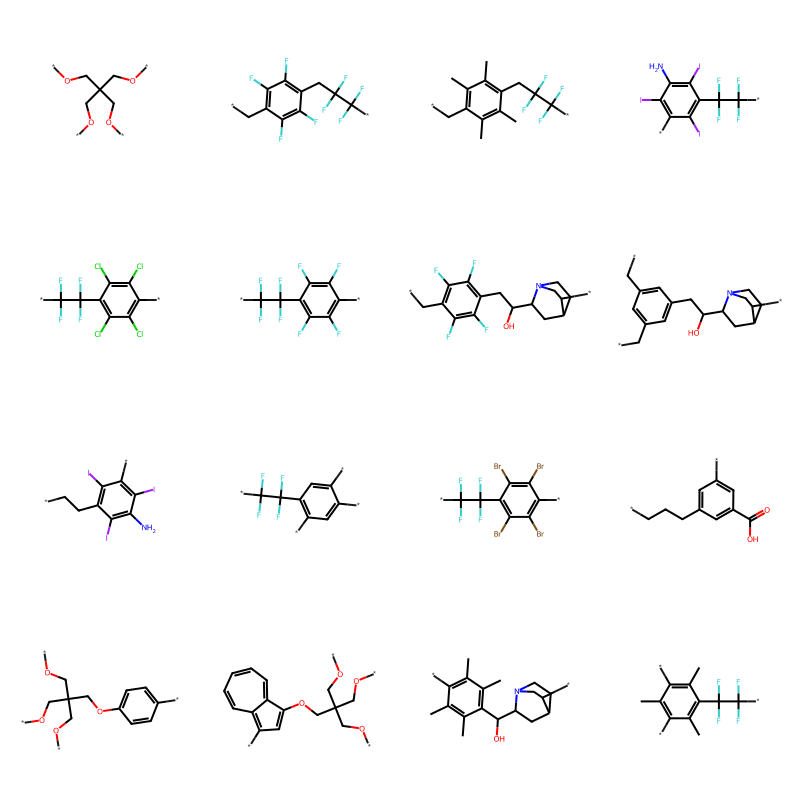

In [55]:
img = Chem.Draw.MolsToGridImage(top_ol[:16], molsPerRow=4,  subImgSize=[200, 200], useSVG=True)
img

### top common metal clusters

In [60]:
import pormake as pm
from ase.visualize.plot import plot_atoms
database = pm.Database()

In [61]:
# topology
counter = Counter()
counter.update(sorted_ret[:, 1].tolist())
top_topo, count = zip(*counter.most_common())
len(top_topo)

27

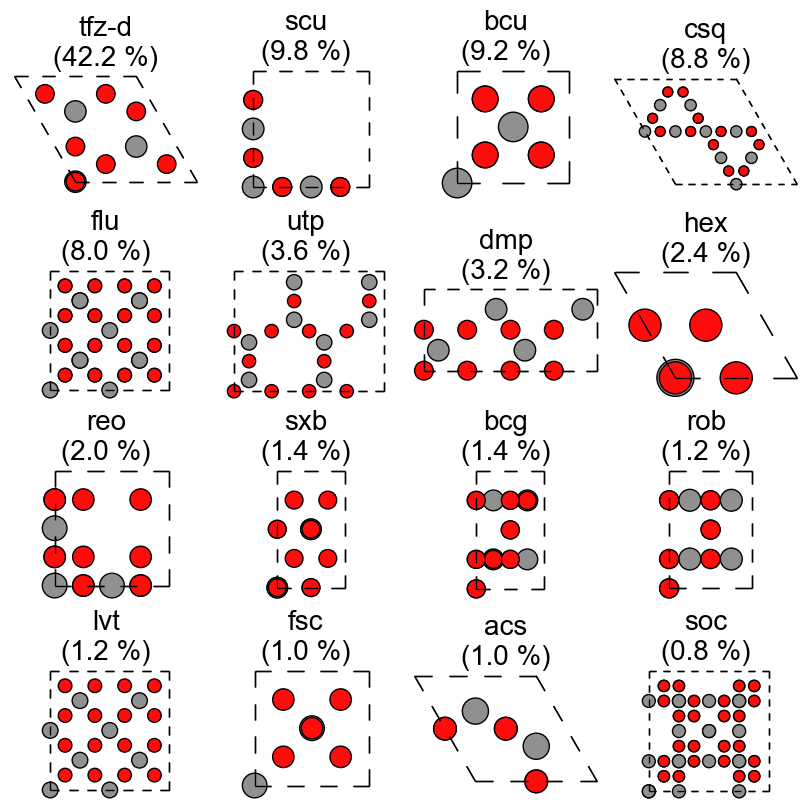

In [62]:
top_topo = top_topo[:16]
fig, axes = plt.subplots(len(top_topo) // 4, 4, figsize=(8, 8), constrained_layout=True)
for i, t in enumerate(top_topo):
    ax = axes[i//4, i%4]
    topo_ = database.get_topo(t)
    plot_atoms(topo_.atoms, ax=ax, radii=0.2)
    ax.set_title(f"{t}\n({round(count[i]/sum(count) * 100, 1)} %)", fontsize=20)
    ax.set_axis_off()

### top common metal clusters

In [63]:
# metal cluster
counter = Counter()
counter.update(sorted_ret[:, 2].tolist())
top_mc, count = zip(*counter.most_common())
len(top_mc)

34

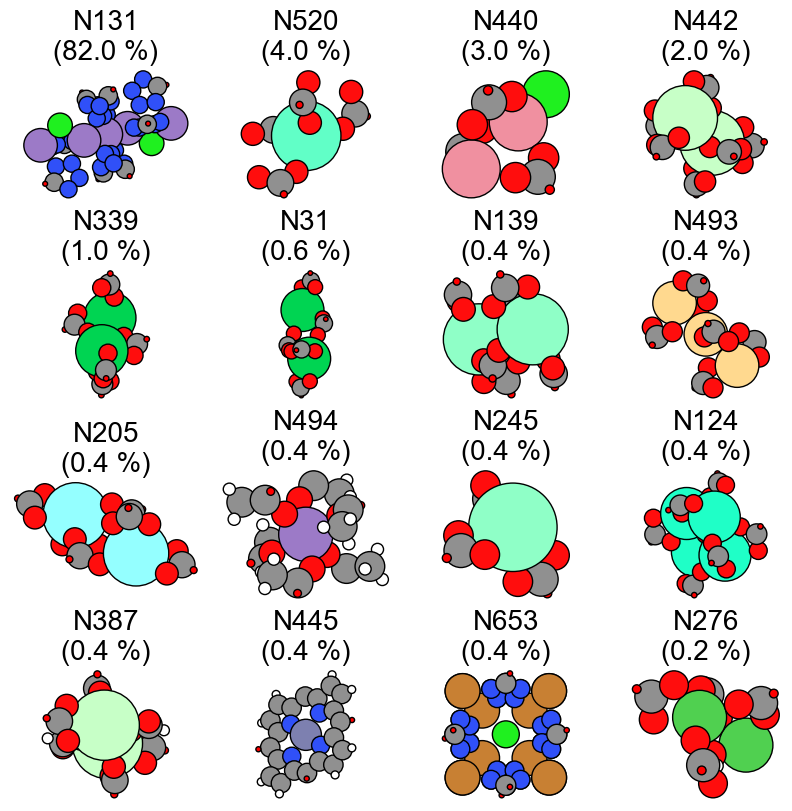

In [64]:
top_mc = top_mc[:16]
fig, axes = plt.subplots(len(top_mc) // 4, 4, figsize=(8, 8), constrained_layout=True)
for i, mc in enumerate(top_mc):
    ax = axes[i//4, i%4]
    mc_ = database.get_bb(mc)
    plot_atoms(mc_.atoms, ax=ax)
    ax.set_title(f"{mc}\n({round(count[i]/sum(count) * 100, 1)} %)", fontsize=20)
    ax.set_axis_off()

## 1. contruction of the generated MOFs by PORMAKE

In [65]:
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')                                                                                                                                                           
pm.log.disable_print()
pm.log.disable_file_print()

>>> Console logs (under WARNING level) are disabled.


In [66]:
save_dir_bb = "results/qkh/bb_dir"
save_dir_gen_mofs = "results/qkh/gen_mofs"

In [67]:
# move node bbs from origin bb_dir (PORMAKE) to new bb_dir
if os.path.exists(save_dir_bb):
    shutil.rmtree(save_dir_bb)
shutil.copytree(f"{pm.__path__[0]}/database/bbs", save_dir_bb)
# bb_dir
database = pm.Database(bb_dir=Path(save_dir_bb))
# save_dir for generated MOFs
os.makedirs(save_dir_gen_mofs, exist_ok=True)

In [94]:
def smiles_to_xyz(smiles, save_dir, bb_name="tmp"):
    # smiles to mol
    mol = Chem.MolFromSmiles(smiles)
    # mol to 3D mol
    m = Chem.AddHs(mol)
    AllChem.EmbedMolecule(m)
    AllChem.MMFFOptimizeMolecule(m)
    # mol to molblock
    mol_block = Chem.MolToMolBlock(m)
    lines = mol_block.splitlines()
    # write xyz file
    line = lines[3]
    num_atoms = int(line[:3])
    num_bonds = int(line[3:6])
    
    save_path = os.path.join(save_dir, f"{bb_name}.xyz")
    with open(save_path, "w") as f:
        f.write(f"{num_atoms}\n")
        f.write(f"mol to xyz file\n")
        # coords
        for line in lines[4:4+num_atoms]:
            tokens = line.split()
            # change dummy atoms R to X
            if tokens[3] == "R":
                tokens[3] = "X"
            f.write(f"{tokens[3]:<10}    {tokens[0]:<10}    {tokens[1]:<10}    {tokens[2]:<10}\n")
        # bonds
        for line in lines[4+num_atoms:4+num_atoms+num_bonds]:
            tokens = [int(line[:3]), int(line[3:6]), int(line[6:9])]
            # bond type
            if tokens[2] == 1:
                bond_type = "S"
            elif tokens[2] == 2:
                bond_type = "D"
            elif tokens[2] == 3:
                bond_type = "T"
            elif tokens[2] == 4:
                bond_type = "A"
            else:
                raise Exception("bond type error")
            # find index of atom
            idx_1 = int(tokens[0]) - 1
            idx_2 = int(tokens[1]) - 1
            f.write(f"{idx_1:<10}{idx_2:<6}{bond_type:<6}\n")
        f.close()

In [95]:
def construct_mofs(final_ret, save_dir_bb, save_dir_gen_mofs):
    e0 = 0 # build error
    e1 = 0
    e2 = 0
    e3 = 0
    e4 = 0

    idx = 0
    vocab_sm = {}
    for p, topo_, mc_, sm_ in tqdm(final_ret):
        print(p, topo_, mc_, sm_)
        # save smiles to xyz file
        try:
            if sm_ not in vocab_sm.keys():
                smiles_to_xyz(sm_, save_dir=save_dir_bb, bb_name=f"{len(vocab_sm)}")
                vocab_sm[sm_] = f"{len(vocab_sm)}"
        except Exception as e:
            e0 += 1
            print("The smile of organice linker can't be converted to xyz files")
            continue


        # get topo, mc, ol
        topo = database.get_topo(topo_)
        mc = database.get_bb(mc_)
        ol = database.get_bb(vocab_sm[sm_])

        # check connection point matching
        topo_cn = list(topo.unique_cn)
        if len(topo_cn) == 1:
            topo_cn.append(2)
        mc_cn = mc.n_connection_points
        ol_cn = sm_.count("*")

        if set(topo_cn) != set([mc_cn, ol_cn]):
            print(f"fail : {topo_cn, mc_cn, ol_cn}")
            continue

        # assingn node and edge
        if mc_cn == topo_cn[0] and topo_cn[1] == 2:
            node_bbs = {
                0 : mc,
            }
            edge_bbs = {
                tuple(topo.unique_edge_types[0]) : ol,
            }
        elif mc_cn == topo_cn[0] and topo_cn[1] != 2:
            node_bbs = {
                0 : mc,
                1 : ol,
            }
            edge_bbs = {}
        else:
            node_bbs = {
                0 : ol,
                1 : mc,
            }
            edge_bbs = {}
        # build MOF
        builder = pm.Builder()
        try:
            gen_mof = builder.build_by_type(topology=topo, node_bbs=node_bbs, edge_bbs=edge_bbs)
        except Exception as e:
            e0 += 1
            continue

        # check criterion
        # (1) SAscore < 6
        m = Chem.MolFromSmiles(sm_)
        score = sascorer.calculateScore(m)
        if score > 6:
            e1 += 1
            continue
        # (2) rmsd
        if gen_mof.info["max_rmsd"] > 0.3:
            e2 += 1
            continue
        # (3) # of atoms <= 3000
        if len(gen_mof.atoms) > 3000:
            e3 += 1
            continue
        # (4) length of cells < 60 A
        if gen_mof.atoms.get_cell_lengths_and_angles()[:3].max() > 60:
            e4 += 1
            continue

        # write cif
        try:
            filename = f"{str(idx).zfill(3)}_{topo_}+{mc_}+{vocab_sm[sm_]}.cif"
            print(f"write_cif {filename}")
            gen_mof.write_cif(f"{save_dir_gen_mofs}/{filename}")
            idx += 1
        except:
            e0 += 1
    # write vocab for smiles of organice linker
    json.dump(vocab_sm, open(f"{save_dir_gen_mofs}/vocab_sm.json", "w"))

In [96]:
# construct top 100 MOFs
final_ret = sorted_ret[:100]
construct_mofs(final_ret, save_dir_bb, save_dir_gen_mofs)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

-57.98576354980469 rob N31 *C1=C(C)C(C)=C(C(O)C2CC3CCN2CC3*)C(C)=C1C


/home/hspark8/anaconda3/envs/MOFreinforce/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


write_cif 000_rob+N31+0.cif


  1%|▍                                          | 1/100 [00:00<01:28,  1.11it/s]

-57.714866638183594 tfz-d N131 *CC(*)CC1=CC=C2C(=C1)OC3=CC(*)=CC=C32


  2%|▊                                          | 2/100 [00:01<00:54,  1.78it/s]

-57.712249755859375 tfz-d N131 *C1=CC(*)=CC(C2CCC(*)CC2)=C1


  3%|█▎                                         | 3/100 [00:01<00:43,  2.25it/s]

-57.673553466796875 tfz-d N131 *CC(*)CC1=CC(*)=CC(C(=O)O)=C1


  4%|█▋                                         | 4/100 [00:01<00:37,  2.59it/s]

-57.66290283203125 sxb N339 *C1=CN=CC(C2=C(Cl)C(Cl)=C(*)C(Cl)=C2Cl)=C1


  5%|██▏                                        | 5/100 [00:02<00:39,  2.42it/s]

write_cif 001_sxb+N339+4.cif
-57.655181884765625 tfz-d N131 *CC(*)CC1=CC=C2C(=C1)C(=O)C3=CC(*)=CC=C32


  6%|██▌                                        | 6/100 [00:02<00:34,  2.73it/s]

-57.65373229980469 tfz-d N131 *CC1=CC(C*)=CC(CC2=CC=C3C=C(*)C=CC3=C2)=C1


  7%|███                                        | 7/100 [00:02<00:33,  2.78it/s]

-57.64801025390625 tfz-d N131 *CC1=CC(C*)=CC(CC2=CC(*)=C3C=CC=CC=C23)=C1


  8%|███▍                                       | 8/100 [00:03<00:37,  2.42it/s]

write_cif 002_tfz-d+N131+7.cif
-57.63631820678711 tfz-d N131 *CC(*)CC1=CC=C(*)C2=CC=CC=C12


  9%|███▊                                       | 9/100 [00:03<00:34,  2.64it/s]

-57.628177642822266 sxb N139 *CC1=C(F)C(F)=C(CC(O)C2CC3CCN2CC3*)C(F)=C1F


 10%|████▏                                     | 10/100 [00:04<00:39,  2.30it/s]

write_cif 003_sxb+N139+9.cif
-57.60702133178711 tfz-d N131 *CCC1=CC(*)=C(O)C=C1*


 11%|████▌                                     | 11/100 [00:04<00:39,  2.23it/s]

write_cif 004_tfz-d+N131+10.cif
-57.58871841430664 tfz-d N131 *CC(*)C1=C(C)C(C)=C(*)C(C)=C1C


 12%|█████                                     | 12/100 [00:05<00:35,  2.46it/s]

-57.5885009765625 tfz-d N131 *CC(*)CC1=CC(*)=CC(N2C=CN=C2)=C1


 13%|█████▍                                    | 13/100 [00:05<00:33,  2.60it/s]

-57.58610153198242 tfz-d N131 *CC(*)CC1=C(C)C(C)=C(*)C(C)=C1C


 14%|█████▉                                    | 14/100 [00:05<00:31,  2.72it/s]

-57.56284713745117 tfz-d N131 *C#CCC1=CC(C*)=CC(C*)=C1


 15%|██████▎                                   | 15/100 [00:06<00:33,  2.54it/s]

write_cif 005_tfz-d+N131+14.cif
-57.560874938964844 tfz-d N131 *CCCC1=CC(C*)=CC(C*)=C1


 16%|██████▋                                   | 16/100 [00:06<00:33,  2.48it/s]

write_cif 006_tfz-d+N131+15.cif
-57.54999923706055 tfz-d N131 *C1=CC(OC)=CC(C2=C(I)C(*)=C(I)C(*)=C2I)=C1


 17%|███████▏                                  | 17/100 [00:06<00:31,  2.66it/s]

-57.53645706176758 tfz-d N131 *CCCC1=C(C)C(*)=C(C)C(*)=C1C


 18%|███████▌                                  | 18/100 [00:07<00:29,  2.74it/s]

-57.50984191894531 rob N339 *C1=CC(O)=CC(C2=CC=C3C(=C2)C(CCC)(CCC)C4=CC(*)=CC=C43)=C1


 19%|███████▉                                  | 19/100 [00:07<00:34,  2.35it/s]

write_cif 007_rob+N339+18.cif
-57.49740982055664 tfz-d N131 *CC1=CC(C*)=CC(CC(O)C2CC3CCN2CC3*)=C1


 20%|████████▍                                 | 20/100 [00:08<00:31,  2.57it/s]

-57.49679183959961 tfz-d N131 *C1=C(C)C(*)=C(C)C(C=2SC(*)=C3C=2OCCO3)=C1C


 21%|████████▊                                 | 21/100 [00:08<00:29,  2.66it/s]

-57.48889923095703 tfz-d N131 *CCC1=C(O)C(*)=C(O)C(*)=C1O
write_cif 008_tfz-d+N131+21.cif


 22%|█████████▏                                | 22/100 [00:09<00:33,  2.34it/s]

-57.48237609863281 tfz-d N131 *CCCCCCCC1=C(O)C(*)=C(O)C(*)=C1O


 23%|█████████▋                                | 23/100 [00:09<00:30,  2.52it/s]

-57.458805084228516 tfz-d N131 *C1=C(C)C(*)=C(C)C(C(F)(F)C(*)(F)F)=C1C
write_cif 009_tfz-d+N131+23.cif


 24%|██████████                                | 24/100 [00:09<00:33,  2.24it/s]

-57.44501876831055 tfz-d N131 *CC(*)CC1=CC2=CC=C3C=C(*)C=C4C=CC(=C1)C2=C34


 25%|██████████▌                               | 25/100 [00:10<00:30,  2.46it/s]

-57.4427604675293 tfz-d N131 *CCC1=C(C)C(*)=C(C)C(*)=C1C
write_cif 010_tfz-d+N131+25.cif


 26%|██████████▉                               | 26/100 [00:10<00:33,  2.18it/s]

-57.44272232055664 tfz-d N131 *CC(*)CC1=CC(*)=CC(Br)=C1


 27%|███████████▎                              | 27/100 [00:11<00:30,  2.40it/s]

-57.43648147583008 tfz-d N131 *C1=CN=CC(C2=C(C)C(*)=C(C)C(*)=C2C)=C1


 28%|███████████▊                              | 28/100 [00:11<00:27,  2.59it/s]

-57.43541717529297 tfz-d N131 *C1=C(I)C(*)=C(I)C(C(F)(F)C(*)(F)F)=C1I


 29%|████████████▏                             | 29/100 [00:11<00:30,  2.35it/s]

write_cif 011_tfz-d+N131+28.cif
-57.41657638549805 tfz-d N131 *CCCC1=C(I)C(*)=C(I)C(*)=C1I


 30%|████████████▌                             | 30/100 [00:12<00:27,  2.55it/s]

-57.396324157714844 sxb N339 *C1=CC(O)=CC(C2=CC(*)=CC(O)=C2)=C1


 31%|█████████████                             | 31/100 [00:12<00:29,  2.37it/s]

write_cif 012_sxb+N339+30.cif
-57.38733673095703 utp N440 *CC1=CC=CC(CC(F)(F)C(*)(F)F)=C1
write_cif 013_utp+N440+31.cif


 32%|█████████████▍                            | 32/100 [00:13<00:36,  1.86it/s]

-57.38019561767578 tfz-d N131 *CC(*)CC1=CC(*)=CC(O)=C1


 33%|█████████████▊                            | 33/100 [00:13<00:29,  2.24it/s]

-57.363624572753906 utp N440 *C1=CC(C)=C(C(F)(F)C(*)(F)F)C=C1C
write_cif 014_utp+N440+33.cif


 34%|██████████████▎                           | 34/100 [00:14<00:40,  1.64it/s]

-57.35959243774414 tfz-d N131 *CC(*)CC1=CC=C(*)S1


 35%|██████████████▋                           | 35/100 [00:15<00:32,  2.02it/s]

-57.354347229003906 tfz-d N131 *CC1=CC(C*)=CC(CC23C=CC(*)(C=C2)C=C3)=C1


 36%|███████████████                           | 36/100 [00:15<00:31,  2.03it/s]

write_cif 015_tfz-d+N131+35.cif
-57.350711822509766 tfz-d N131 *C1=CN=C(C2=CC(*)=CC(*)=C2)N=C1


 37%|███████████████▌                          | 37/100 [00:15<00:27,  2.25it/s]

-57.336238861083984 tfz-d N131 *CC(*)C1=CC=C(*)C=C1


 38%|███████████████▉                          | 38/100 [00:16<00:24,  2.51it/s]

-57.22397994995117 tfz-d N131 *CC1=CC=CC=C1CC2=CC(*)=NC(*)=C2
write_cif 016_tfz-d+N131+38.cif


 39%|████████████████▍                         | 39/100 [00:16<00:28,  2.15it/s]

-57.21329879760742 tfz-d N131 *C1=CC(*)=CC(C(F)(F)C(*)(F)F)=C1


 40%|████████████████▊                         | 40/100 [00:17<00:27,  2.18it/s]

write_cif 017_tfz-d+N131+39.cif
-57.15534591674805 tfz-d N131 *CC(*)C1=CC(*)=CC(N2C=CN=C2)=C1


 41%|█████████████████▏                        | 41/100 [00:17<00:23,  2.48it/s]

-57.11495590209961 tfz-d N131 *C1=CC(*)=CC(C2=CC(*)=C3C=CC=CC=C23)=C1


 42%|█████████████████▋                        | 42/100 [00:17<00:21,  2.68it/s]

-57.10672378540039 tfz-d N131 *CC(*)CC1=CC=C(*)O1


 43%|██████████████████                        | 43/100 [00:18<00:19,  2.86it/s]

-57.09872055053711 tfz-d N131 *C1=C(Br)C(Br)=C(N2C=C3C4=CN(*)C=C4C5=CN(*)C=C5C3=C2)C(Br)=C1Br


 44%|██████████████████▍                       | 44/100 [00:18<00:20,  2.76it/s]

write_cif 018_tfz-d+N131+43.cif
-57.08470916748047 utp N440 *CC1=C(F)C(F)=C(CC2=C(Br)C(Br)=C(*)C(Br)=C2Br)C(F)=C1F
write_cif 019_utp+N440+44.cif


 45%|██████████████████▉                       | 45/100 [00:19<00:23,  2.33it/s]

-57.08182907104492 tfz-d N131 *C1=CC(Br)=CC(N2C=C3C4=CN(*)C=C4C5=CN(*)C=C5C3=C2)=C1


 46%|███████████████████▎                      | 46/100 [00:19<00:23,  2.31it/s]

write_cif 020_tfz-d+N131+45.cif
-57.07155990600586 tfz-d N131 *C1=CC(*)=CC(C2=CN(*)N=N2)=C1


 47%|███████████████████▋                      | 47/100 [00:19<00:20,  2.56it/s]

-57.06612014770508 tfz-d N131 *C1=CC(OC)=CC(C2=C(O)C(*)=C(O)C(*)=C2O)=C1


 48%|████████████████████▏                     | 48/100 [00:20<00:19,  2.67it/s]

-57.048431396484375 tfz-d N131 *CC1=CC(C*)=CC(CC2=NN=C(*)N2N)=C1


 49%|████████████████████▌                     | 49/100 [00:20<00:20,  2.51it/s]

write_cif 021_tfz-d+N131+48.cif
-56.988372802734375 tfz-d N131 *C1=NN=C(C2=C(I)C(*)=C(I)C(*)=C2I)N=N1


 50%|█████████████████████                     | 50/100 [00:20<00:18,  2.66it/s]

-56.96603012084961 tfz-d N131 *CC(*)CC12CC3CC(CC(*)(C3)C1)C2


 51%|█████████████████████▍                    | 51/100 [00:21<00:18,  2.70it/s]

-56.96503448486328 tfz-d N131 *CC1=CC(C*)=CC(CC(F)(F)C(*)(F)F)=C1
write_cif 022_tfz-d+N131+51.cif


 52%|█████████████████████▊                    | 52/100 [00:21<00:20,  2.30it/s]

-56.935543060302734 tfz-d N131 *C1=C(C)C(*)=C(C)C(C2CCC(*)CC2)=C1C


 53%|██████████████████████▎                   | 53/100 [00:22<00:19,  2.46it/s]

-56.92310333251953 tfz-d N131 *C1=C(O)C(*)=C(O)C(C2CCC(*)CC2)=C1O


 54%|██████████████████████▋                   | 54/100 [00:22<00:17,  2.56it/s]

-56.910247802734375 utp N440 *CCC1=C(F)C(F)=C(*)C(F)=C1F
write_cif 023_utp+N440+54.cif


 55%|███████████████████████                   | 55/100 [00:23<00:21,  2.12it/s]

-56.890602111816406 tfz-d N131 *CCCCCC1=CC(*)=CC(*)=C1


 56%|███████████████████████▌                  | 56/100 [00:23<00:18,  2.40it/s]

-56.863529205322266 tfz-d N131 *CC(*)C1=C(Cl)C(Cl)=C(*)C(Cl)=C1Cl


 57%|███████████████████████▉                  | 57/100 [00:23<00:17,  2.51it/s]

-56.84865951538086 tfz-d N131 *CC(*)CC1CCC(*)(C)C1(C)C


 58%|████████████████████████▎                 | 58/100 [00:24<00:16,  2.58it/s]

-56.78512191772461 tfz-d N131 *C1=CC(C(F)(F)C(*)(F)F)=CC(*)=N1


 59%|████████████████████████▊                 | 59/100 [00:24<00:16,  2.43it/s]

write_cif 024_tfz-d+N131+58.cif
-56.736412048339844 tfz-d N131 *C1=C(C)C(*)=C(C)C(C(O)C2CC3CCN2CC3*)=C1C


 60%|█████████████████████████▏                | 60/100 [00:24<00:15,  2.66it/s]

-56.726993560791016 dmp N276 *NC(O)C(*)O
The smile of organice linker can't be converted to xyz files
-56.6976203918457 tfz-d N131 *CCCC1=CC(*)=C(O)C=C1*
write_cif 025_tfz-d+N131+60.cif


 62%|██████████████████████████                | 62/100 [00:25<00:12,  3.07it/s]

-56.63150405883789 tfz-d N131 *CC(*)CC1=NC(C)=C(*)S1


 63%|██████████████████████████▍               | 63/100 [00:25<00:11,  3.17it/s]

-56.62944793701172 scu N131 *OCC(CO*)(CO*)CO*


 64%|██████████████████████████▉               | 64/100 [00:26<00:12,  2.85it/s]

-56.61219787597656 tfz-d N131 *CC(*)CC1=C2C=CC=CC2=C(*)C3=CC=CC=C13


 65%|███████████████████████████▎              | 65/100 [00:26<00:12,  2.91it/s]

-56.60247802734375 tfz-d N131 *CC(*)C1=CC=C(C2=CC=C(*)S2)S1


 66%|███████████████████████████▋              | 66/100 [00:26<00:12,  2.82it/s]

-56.58261489868164 tfz-d N131 *CCCCCCC1=C(I)C(*)=C(I)C(*)=C1I


 67%|████████████████████████████▏             | 67/100 [00:27<00:11,  2.99it/s]

-56.575992584228516 tfz-d N131 *C1=C(C)C(*)=C(C)C(C2=CN(*)N=N2)=C1C


 68%|████████████████████████████▌             | 68/100 [00:27<00:10,  2.96it/s]

-56.563934326171875 tfz-d N131 *CC1=C(F)C(F)=C(CC2=C(I)C(*)=C(I)C(*)=C2I)C(F)=C1F


 69%|████████████████████████████▉             | 69/100 [00:27<00:09,  3.11it/s]

-56.54543685913086 tfz-d N131 *C1=CC(*)=CC(C2=CC=C(*)S2)=C1


 70%|█████████████████████████████▍            | 70/100 [00:28<00:09,  3.18it/s]

-56.54450225830078 tfz-d N131 *CC(*)CC1=CC2=CC=C(*)C=C2CC1


 71%|█████████████████████████████▊            | 71/100 [00:28<00:09,  2.99it/s]

-56.50014114379883 rob N31 *C1=CC=C(C2=CC=C(C=3SC(*)=C4C=3OCCO4)C=C2)C=C1


 72%|██████████████████████████████▏           | 72/100 [00:29<00:11,  2.47it/s]

write_cif 026_rob+N31+70.cif
-56.478477478027344 tfz-d N131 *CC(*)CC1=C(Br)C(Br)=C(*)C(Br)=C1Br


 73%|██████████████████████████████▋           | 73/100 [00:29<00:09,  2.71it/s]

-56.46727752685547 tfz-d N131 *C1=C(C)C(*)=C(C)C(C2=C(C)C(C)=C(C(O)C3CC4CCN3CC4*)C(C)=C2C)=C1C


 74%|███████████████████████████████           | 74/100 [00:29<00:09,  2.68it/s]

-56.46046447753906 tfz-d N131 *C1=CC(*)=CC(C2=C3C=CC=CC3=C(*)C4=CC=CC=C24)=C1


 75%|███████████████████████████████▌          | 75/100 [00:30<00:08,  2.87it/s]

-56.45917510986328 tfz-d N131 *CC(*)C1=CC=C(C(OC)C(OC)C2=CC=C(*)C=C2)C=C1


 76%|███████████████████████████████▉          | 76/100 [00:30<00:08,  2.95it/s]

-56.44548416137695 tfz-d N131 *CC(*)CC1=CC=C(*)C2=C1CC2


 77%|████████████████████████████████▎         | 77/100 [00:30<00:07,  3.06it/s]

-56.42641067504883 sxb N31 *CCC1=CC=C(CCC2=C(F)C(F)=C(*)C(F)=C2F)C=C1


 78%|████████████████████████████████▊         | 78/100 [00:31<00:08,  2.63it/s]

write_cif 027_sxb+N31+76.cif
-56.41630554199219 tfz-d N131 *C1=NC(*)=NC(C2=C(Br)C(Br)=C(*)C(Br)=C2Br)=N1


 79%|█████████████████████████████████▏        | 79/100 [00:31<00:07,  2.90it/s]

-56.402957916259766 utp N440 *CC1=C(F)C(F)=C(CC2=CC=C(*)C(N)=C2)C(F)=C1F
write_cif 028_utp+N440+78.cif


 80%|█████████████████████████████████▌        | 80/100 [00:32<00:09,  2.14it/s]

-56.38399124145508 tfz-d N131 *C1=CC(*)=CC(C2=C(F)C(F)=C(*)C(F)=C2F)=C1


 81%|██████████████████████████████████        | 81/100 [00:32<00:07,  2.53it/s]

-56.383609771728516 tfz-d N131 *CC(*)CC1=CC=C(*)N=C1


 82%|██████████████████████████████████▍       | 82/100 [00:32<00:06,  2.64it/s]

-56.26512908935547 tfz-d N131 *CCC1=C(I)C(*)=C(I)C(*)=C1I


 83%|██████████████████████████████████▊       | 83/100 [00:33<00:07,  2.33it/s]

write_cif 029_tfz-d+N131+81.cif
-56.25897216796875 tfz-d N131 *C1=C(I)C(*)=C(I)C(CC(*)N)=C1I


 84%|███████████████████████████████████▎      | 84/100 [00:33<00:06,  2.57it/s]

-56.21750259399414 flu N131 *CC(*)CC1=C(O)C(*)=C(O)C(*)=C1O


 85%|███████████████████████████████████▋      | 85/100 [00:34<00:06,  2.32it/s]

-56.202545166015625 tfz-d N131 *CC1=CC(C*)=CC(CC2=CC(*)=CC(Br)=C2)=C1


 86%|████████████████████████████████████      | 86/100 [00:34<00:06,  2.25it/s]

write_cif 030_tfz-d+N131+84.cif
-56.13064956665039 tfz-d N131 *C1=CC(C2=C(Cl)C(Cl)=C(*)C(Cl)=C2Cl)=C(*)C=C1O
write_cif 031_tfz-d+N131+85.cif


 87%|████████████████████████████████████▌     | 87/100 [00:35<00:06,  2.12it/s]

-56.081546783447266 tfz-d N131 *CC1=C(C)C(C)=C(CC2=CC(*)=NC(*)=C2)C(C)=C1C


 88%|████████████████████████████████████▉     | 88/100 [00:35<00:05,  2.31it/s]

-56.0617561340332 tfz-d N131 *CC(*)C1=CC=C(C2=CC=C(*)C=N2)C=C1


 89%|█████████████████████████████████████▍    | 89/100 [00:35<00:04,  2.46it/s]

-56.038848876953125 tfz-d N131 *C1=C(O)C(*)=C(O)C(C2=C(Br)C(Br)=C(*)C(Br)=C2Br)=C1O


 90%|█████████████████████████████████████▊    | 90/100 [00:36<00:03,  2.59it/s]

-55.95928192138672 utp N440 *CC1=C(F)C(F)=C(CC2=CC=C(*)C(F)=C2F)C(F)=C1F
write_cif 032_utp+N440+89.cif


 91%|██████████████████████████████████████▏   | 91/100 [00:36<00:04,  2.00it/s]

-55.95680236816406 csq N131 *OCC(CO*)(CO*)CO*


 92%|██████████████████████████████████████▋   | 92/100 [00:37<00:04,  1.88it/s]

-55.953922271728516 tfz-d N131 *CC(*)CC12C=CC(*)(C=C1)C=C2


 93%|███████████████████████████████████████   | 93/100 [00:37<00:03,  2.10it/s]

-55.93686294555664 tfz-d N131 *CC1=CC(C*)=CC(CC2=CC=C(*)C(N)=C2)=C1


 94%|███████████████████████████████████████▍  | 94/100 [00:38<00:02,  2.08it/s]

write_cif 033_tfz-d+N131+91.cif
-55.897159576416016 tfz-d N131 *C1=CC(*)=CC(C2=NC=C(C3=CC=C(*)O3)C=N2)=C1


 95%|███████████████████████████████████████▉  | 95/100 [00:38<00:02,  2.30it/s]

-55.86309814453125 utp N51 *C1=C(C(C)C)C=C(C(F)(F)C(*)(F)F)C=C1C(C)C
write_cif 034_utp+N51+93.cif


 96%|████████████████████████████████████████▎ | 96/100 [00:39<00:01,  2.09it/s]

-55.841487884521484 tfz-d N131 *C1=NN=C(C2=C(C)C(*)=C(C)C(*)=C2C)O1


 97%|████████████████████████████████████████▋ | 97/100 [00:39<00:01,  2.40it/s]

-55.83877182006836 bcu N131 *CC1=CC=C(CC2=CC=C(*)C3=CC=CC=C23)C=C1


 98%|█████████████████████████████████████████▏| 98/100 [00:40<00:00,  2.26it/s]

write_cif 035_bcu+N131+95.cif
-55.8175163269043 tfz-d N131 *CC(*)C1=C(Br)C(Br)=C(*)C(Br)=C1Br


 99%|█████████████████████████████████████████▌| 99/100 [00:40<00:00,  2.48it/s]

-55.78976821899414 tfz-d N131 *C1=C(C)C(*)=C(C)C(C2=NC(C)=C(*)S2)=C1C


100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


## 2. visualize the constructed MOFs

In [103]:
filenames = sorted(list(Path(save_dir_gen_mofs).glob("*.cif")))

results/qkh/gen_mofs/001_sxb+N339+4.cif


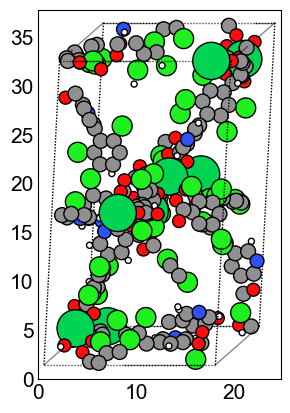

In [106]:
p = filenames[1]
atoms = read(p)
plot_atoms(atoms)
print(p)

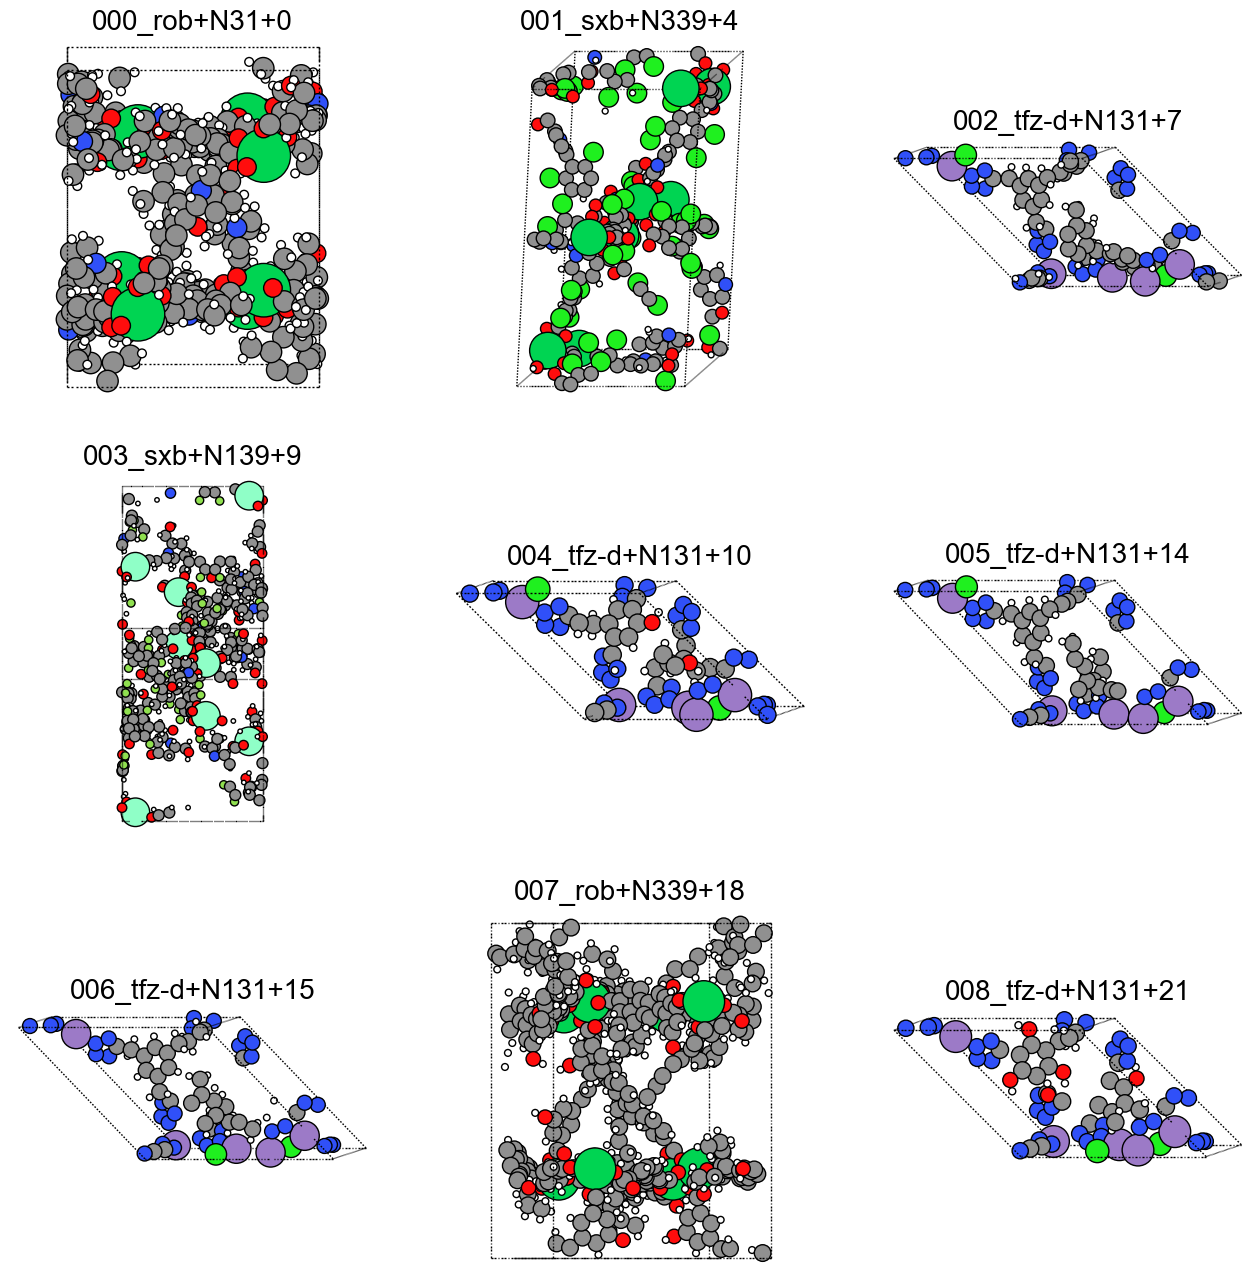

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
for i in range(9):
    ax = axes[i//3, i%3]
    atoms = read(filenames[i])
    plot_atoms(atoms, ax=ax)
    ax.set_title(filenames[i].name.split("/")[-1].split(".")[0], fontsize=20)
    ax.set_axis_off()
plt.show()